# Imports 

In [33]:
import pickle
import gzip

import geopandas as gpd

import matplotlib.pyplot as plt

import numpy as np
import pandas as pd
import seaborn as sns

import rasterio
from rasterio.enums import Resampling
from rasterio.mask import mask
from rasterio.plot import show, plotting_extent
from rasterio.warp import calculate_default_transform, reproject

from shapely.geometry import Point

from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

from pyproj import CRS, Transformer
from tqdm import tqdm

In [2]:
def save_zipped_pickle(obj, filen, protocol=-1):
    r"""
    
    **Description:**
    Saves data in a zipped pickle file.
    
    
    Args:
       obj (array/dict): Data to be stored in file.
       filen (string): Filename of file to be read.
        
    Returns:
        
    
    """
    with gzip.open(filen, 'wb') as f:
        pickle.dump(obj, f, protocol)
        
    f.close()

def load_zipped_pickle(filen):
    r"""
    
    **Description:**
    Returns content of zipped pickle file.
    
    
    Args:
       filen (string): Filename of zipped file to be read.
        
    Returns:
       data (array/dictionary): Data contained in file.
    
    """
    
    with gzip.open(filen, 'rb') as f:
        loaded_object = pickle.load(f)
            
    f.close()
            
    return loaded_object


def plot_feature_importance(model, feature_names, top_n=30):
    """
    For feature importance plot

    Args:
        model: rf regression model with features
        feature_names (list): features from model to be plotted
        top_n (int): number of features to be plotted

    Returns:
        None (the function makes and displays a plot)
    """
    importances = model.feature_importances_
    
    
    importance_df = pd.DataFrame({
        'Feature': feature_names,
        'Importance': importances
    })
    
    # Sort the features by importance
    importance_df = importance_df.sort_values(by='Importance', ascending=False)
    
    if top_n:
        importance_df = importance_df.head(top_n)
    
    plt.figure(figsize=(10, 8))
    sns.barplot(x='Importance', y='Feature', data=importance_df, palette='viridis')
    plt.title('Feature Importance')
    plt.xlabel('Importance')
    plt.ylabel('Feature')
    plt.grid(True)
    # plt.savefig("figures/feature_importance", bbox_inches = 'tight')
    plt.show()
    

# Make/Analyze Random Forest

Mean Squared Error: 0.554852042563773
R² Score: 0.5755973455911414


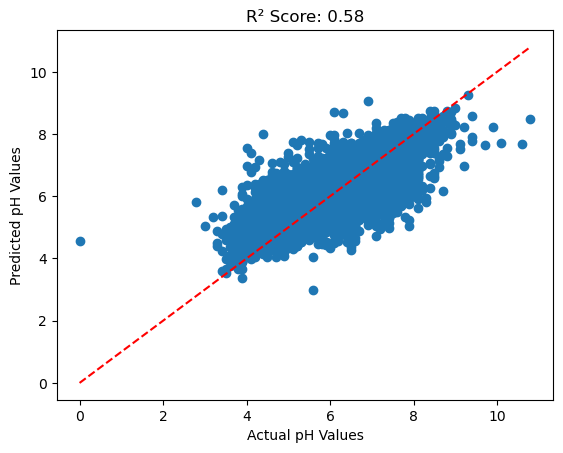

In [4]:
# Training
file_path = "train_81_fr.csv"
df = pd.read_csv(file_path, low_memory=False)
df['geometry'] = df.apply(lambda row: Point(row['longitude_decimal_degrees'], row['latitude_decimal_degrees']), axis=1)
gdf_ncss = gpd.GeoDataFrame(df, geometry='geometry')
# RASTERVALU is pasterland % at 10km from NLCD 2021
of_interest = [
    'temp_season_us_scale_10km', 'temp_ave_us_scale_10km', 'Rs_us_5min', 'porosity_us_scale_5min',
    'sm_0_5_cm_us_scale_10km', 'cec_0_5_cm_us_10km', 'quick_flow_us_scale_10km', 'prec_total_us_scale_10km',
    'prec_season_us_scale_10km', 'population_us_10km', 'npp_annual_us_10km', 'N_fert_manure_sum_per_area_us_10km',
    'N_fert_manure_cropland_sum_per_area_us_10km', 'mixed_us_10km', 'carbonate_us_10km', 'basic_us_10km',
    'acidic_intermediate_us_10km', 'slope_us_scale_10km', 'elevation_us_scale_10km', 'nlcd_cropland_us_scale_10km',
    'vegetation_us_10km', 'urban_us_10km', 'tree_us_10km', 'cropland_us_10km', 'irrFreq_us_10km', 'aei_scale_us_10km',
    'wtd_us_scale_10km', 'et_us_scale_10km', 'RASTERVALU', 'longitude_decimal_degrees', 'latitude_decimal_degrees'
]

# Drop NaN values
gdf_ncss = gdf_ncss.dropna(subset=of_interest)
gdf_ncss.set_crs(epsg=5070, inplace=True)

# Random Forest Model
X = gdf_ncss[of_interest]
y = gdf_ncss['ph_h2o']

model = RandomForestRegressor(random_state=42)
model.fit(X, y)

# Validation
final_final = 'ebk_valid_81.csv'
df_val = pd.read_csv(final_final, low_memory=False)
df_val['geometry'] = df_val.apply(lambda row: Point(row['longitude_decimal_degrees'], row['latitude_decimal_degrees']), axis=1)
vali = gpd.GeoDataFrame(df_val, geometry='geometry')

X_val = vali[of_interest]
y_val = vali['ph_h2o']

y_pred = model.predict(X_val)
mse = mean_squared_error(y_val, y_pred)
r2 = r2_score(y_val, y_pred)


print(f"Mean Squared Error: {mse}")
print(f"R² Score: {r2}")

plt.scatter(y_val, y_pred)
plt.plot([y_val.min(), y_val.max()], [y_val.min(), y_val.max()], 'r--')  # Line for perfect predictions
plt.title(f'R² Score: {r2:.2f}')
plt.xlabel('Actual pH Values')
plt.ylabel('Predicted pH Values')
plt.savefig('figures/rsqredRF')
plt.show()

/var/folders/d4/qv1b2v_s4lj7qjym_pplz35c0000gn/T/ipykernel_1211/3049916031.py:71: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=importance_df, palette='viridis')


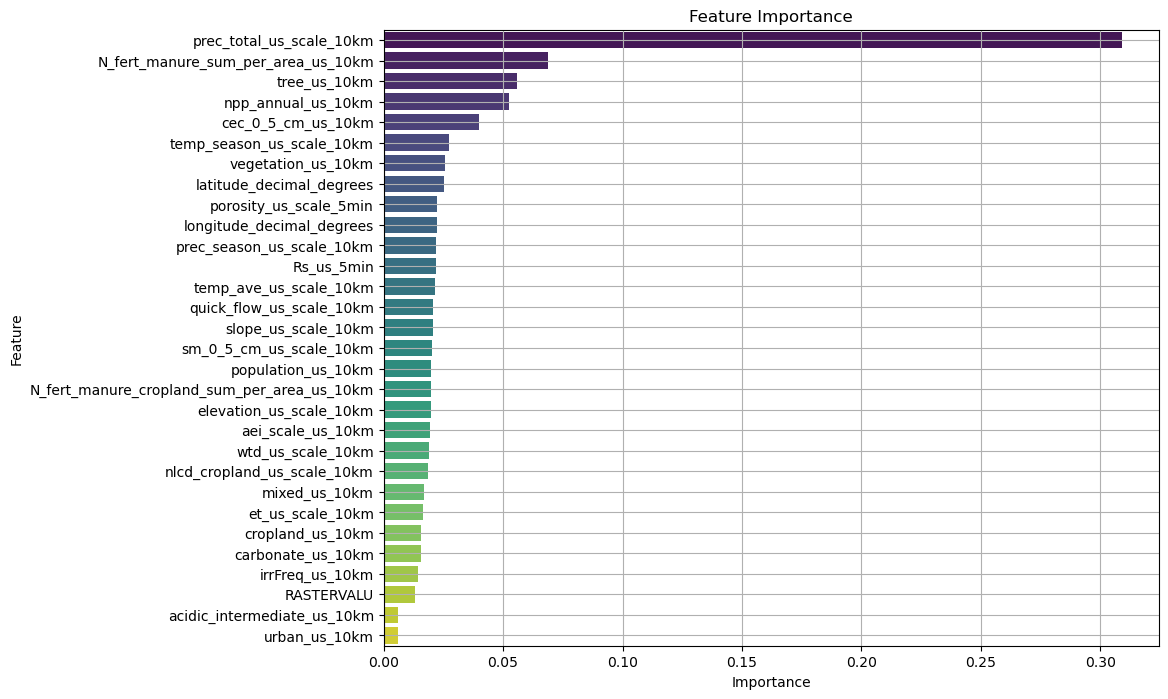

In [5]:
plot_feature_importance(model, X.columns)

/var/folders/d4/qv1b2v_s4lj7qjym_pplz35c0000gn/T/ipykernel_36277/3032675136.py:52: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=importance_df, palette='viridis')


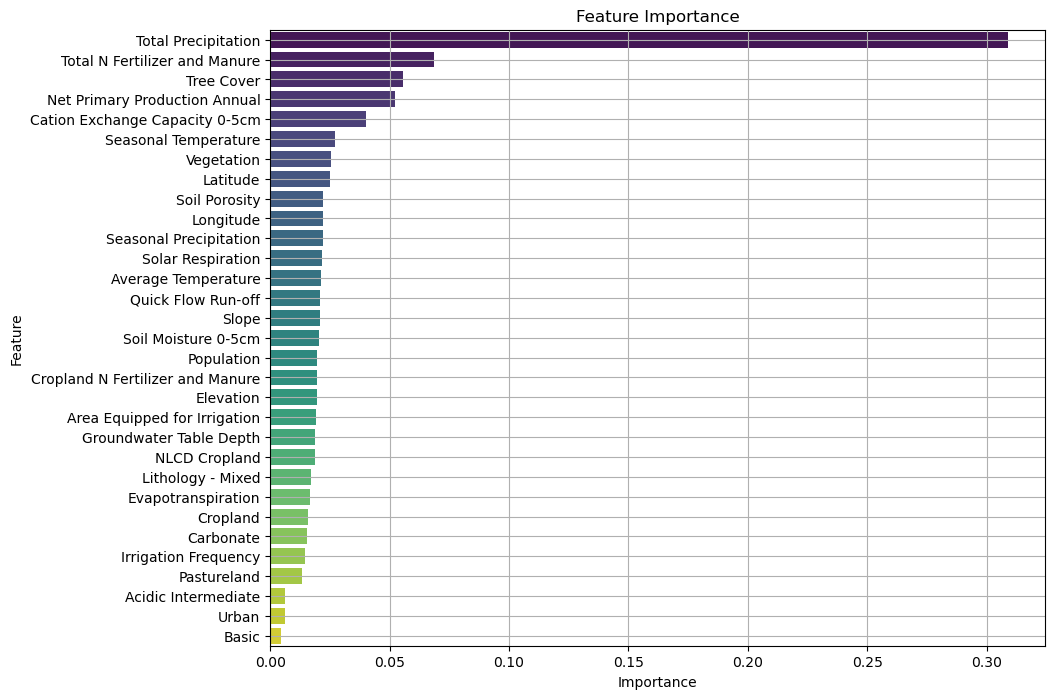

In [335]:
# for presentation 82
feature_name_mapping = {
    'temp_season_us_scale_10km': 'Seasonal Temperature',
    'temp_ave_us_scale_10km': 'Average Temperature',
    'Rs_us_5min': 'Solar Respiration',
    'porosity_us_scale_5min': 'Soil Porosity',
    'sm_0_5_cm_us_scale_10km': 'Soil Moisture 0-5cm',
    'cec_0_5_cm_us_10km': 'Cation Exchange Capacity 0-5cm',
    'quick_flow_us_scale_10km': 'Quick Flow Run-off',
    'prec_total_us_scale_10km': 'Total Precipitation',
    'prec_season_us_scale_10km': 'Seasonal Precipitation',
    'population_us_10km': 'Population',
    'npp_annual_us_10km': 'Net Primary Production Annual',
    'N_fert_manure_sum_per_area_us_10km': 'Total N Fertilizer and Manure',
    'N_fert_manure_cropland_sum_per_area_us_10km': 'Cropland N Fertilizer and Manure',
    'mixed_us_10km': 'Lithology - Mixed',
    'carbonate_us_10km': 'Carbonate',
    'basic_us_10km': 'Basic',
    'acidic_intermediate_us_10km': 'Acidic Intermediate',
    'slope_us_scale_10km': 'Slope',
    'elevation_us_scale_10km': 'Elevation',
    'nlcd_cropland_us_scale_10km': 'NLCD Cropland',
    'vegetation_us_10km': 'Vegetation',
    'urban_us_10km': 'Urban',
    'tree_us_10km': 'Tree Cover',
    'cropland_us_10km': 'Cropland',
    'irrFreq_us_10km': 'Irrigation Frequency',
    'aei_scale_us_10km': 'Area Equipped for Irrigation',
    'wtd_us_scale_10km': 'Groundwater Table Depth',
    'et_us_scale_10km': 'Evapotranspiration',
    'RASTERVALU': 'Pastureland',
    'longitude_decimal_degrees': 'Longitude',
    'latitude_decimal_degrees': 'Latitude'
}
importance_df = pd.DataFrame({
    'Feature': of_interest,
    'Importance': importances
})

importance_df['Feature'] = importance_df['Feature'].map(feature_name_mapping)

importance_df = pd.DataFrame({
    'Feature': of_interest,
    'Importance': model.feature_importances_
})

importance_df['Feature'] = importance_df['Feature'].map(feature_name_mapping)

importance_df = importance_df.sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 8))
sns.barplot(x='Importance', y='Feature', data=importance_df, palette='viridis')
plt.title('Feature Importance')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.grid(True)
plt.savefig("figures/feature_importance", bbox_inches='tight')
plt.show()

In [6]:
raster_paths = {
    'temp_season_us_scale_5min': "Soil_gis_layers_5min_10km/Temperature/temp_season_us_scale_10km.tif",
    'temp_ave_us_scale_5min': "Soil_gis_layers_5min_10km/Temperature/temp_ave_us_scale_10km.tif",
    'Rs_us_5min': "Soil_gis_layers_5min_10km/Soil respiration rate/Rs_us_10km.tif",
    'porosity_us_scale_5min': "Soil_gis_layers_5min_10km/Soil porosity/porosity_us_scale_10km.tif",
    'sm_0_5_cm_us_scale_5min': "Soil_gis_layers_5min_10km/Soil moisture/sm_0_5_cm_us_scale_10km.tif",
    'cec_0_5_cm_us_5min': "Soil_gis_layers_5min_10km/Soil CEC/cec_0_5_cm_us_10km.tif",
    'quick_flow_us_scale_5min': "Soil_gis_layers_5min_10km/Quick-flow runoff/quick_flow_us_scale_10km.tif", 
    'prec_total_us_scale_5min': "Soil_gis_layers_5min_10km/Precipitation/prec_total_us_scale_10km.tif", 
    'prec_season_us_scale_5min': "Soil_gis_layers_5min_10km/Precipitation/prec_season_us_scale_10km.tif", 
    'population_us_5min': "Soil_gis_layers_5min_10km/Population/population_us_10km.tif",
    'npp_annual_us_5min': "Soil_gis_layers_5min_10km/NPP/npp_annual_us_10km.tif",
    'N_fert_manure_sum_per_area_us_5min': "Soil_gis_layers_5min_10km/N application/N_fert_manure_sum_per_area_us_10km.tif", 
    'N_fert_manure_cropland_sum_per_area_us_5min': "Soil_gis_layers_5min_10km/N application/N_fert_manure_cropland_sum_per_area_us_10km.tif",
    'mixed_us_5min': "Soil_gis_layers_5min_10km/Lithology/mixed_us_10km.tif", 
    'carbonate_us_5min': "Soil_gis_layers_5min_10km/Lithology/carbonate_us_10km.tif", 
    'basic_us_5min': "Soil_gis_layers_5min_10km/Lithology/basic_us_10km.tif", 
    'acidic_intermediate_us_5min': "Soil_gis_layers_5min_10km/Lithology/acidic_intermediate_us_10km.tif", 
    'slope_us_scale_5min': "Soil_gis_layers_5min_10km/Land slope/slope_us_scale_10km.tif", 
    'elevation_us_scale_5min': "Soil_gis_layers_5min_10km/Land elevation/elevation_us_scale_10km.tif", 
    'nlcd_cropland_us_scale_5min': "Soil_gis_layers_5min_10km/Land cover_cropland_NLCD/nlcd_cropland_us_scale_10km.tif", 
    'vegetation_us_5min': "Soil_gis_layers_5min_10km/Land cover/vegetation_us_10km.tif", 
    'urban_us_5min': "Soil_gis_layers_5min_10km/Land cover/urban_us_10km.tif", 
    'tree_us_5min': "Soil_gis_layers_5min_10km/Land cover/tree_us_10km.tif", 
    'cropland_us_5min': "Soil_gis_layers_5min_10km/Land cover/cropland_us_10km.tif", 
    'irrFreq_us_5min': "Soil_gis_layers_5min_10km/Irrigation frequency/irrFreq_us_10km.tif", 
    'irrigationAreaProp': "Soil_gis_layers_5min_10km/Irrigation area proportion/aei_scale_us_10km.tif",
    'groundwaterTableDepth_tif': "Soil_gis_layers_5min_10km/Groundwater table depth/wtd_us_scale_10km.tif",
    'evapotranspiration_tif':  "Soil_gis_layers_5min_10km/Evapotranspiration/et_us_scale_10km.tif",
    'pasture_tif': "percentage_81.tif"
}

# Prepare Data

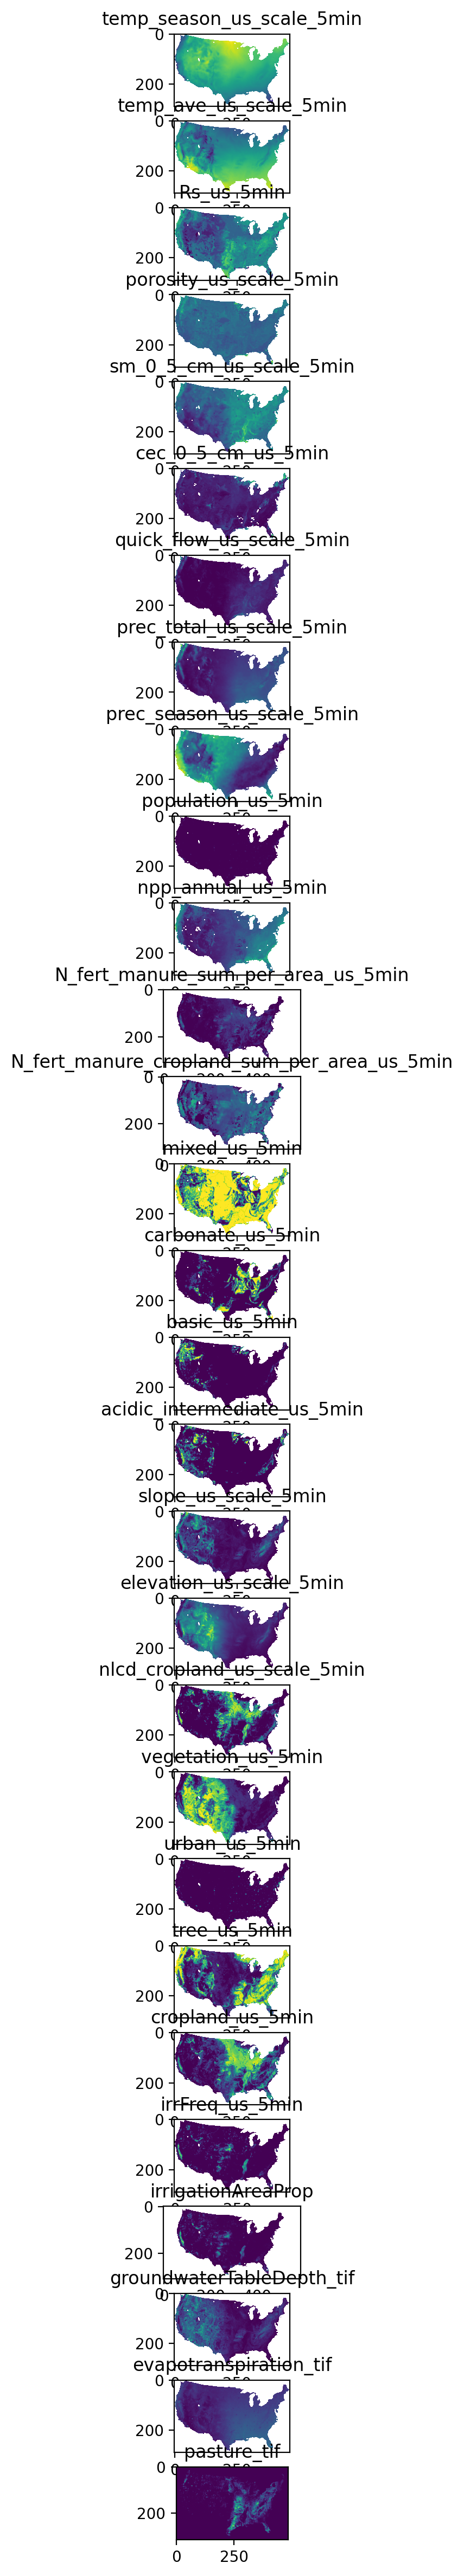

In [7]:
# Visualize rasters
# elevation_us was very big number in sea. now NaN. -999 also changed to NaN in all other files (ArcGis knows)
i = 0
fig, ax = plt.subplots(nrows = len(raster_paths),dpi = 200,figsize = (6,30))
for feature, path in raster_paths.items():
    with rasterio.open(path,'r+') as src:
        data = src.read(1)
        data[data==-9999.0] = float('nan')
        if path ==raster_paths['elevation_us_scale_5min']:
            data[data == data[0][0]] = float('nan')
        kwargs = src.meta.copy()
        kwargs.update({'nodata': 'nan'})
        src.write(data, 1)
        #print(data.shape)
        ax[i].imshow(data)
        ax[i].set_title(feature)
    i+=1

In [8]:
# Region of interest (CONUS)
min_lon, min_lat = -124.75, 24.5
max_lon, max_lat = -66.91666666, 49.41666666
# 10000 m x 10000 m resolution
r = 1
l, w = (290+r, 462+r)

latitudes = np.linspace(min_lat, max_lat, l)
longitudes = np.linspace(min_lon, max_lon, w)
ll = []
for loni, lon in tqdm(enumerate(longitudes),total = len(longitudes)):
    for lati, lat in enumerate(latitudes):
        ll.append((lat,lon))
latlonarr = np.array(ll)

lats = latlonarr.T[0] #<----IMPORTANT
lons = latlonarr.T[1] #<----IMPORTANT

# Define the source and target CRS
crs_wgs84 = CRS.from_epsg(4326)  # WGS84
crs_epsg5070 = CRS.from_epsg(5070)  # EPSG:5070 ALBERS

# Create the transformer
transformer = Transformer.from_crs(crs_wgs84, crs_epsg5070, always_xy=True)

# Transform the coordinates
x5070, y5070 = transformer.transform(lons, lats)

transformed_coords = np.vstack((x5070, y5070)).T #<----IMPORTANT

100%|██████████████████████████████████████| 463/463 [00:00<00:00, 12080.86it/s]


In [54]:
# plt.scatter(transformed_coords.T[0],transformed_coords.T[1])

In [9]:
# create square grid, but in the 5070.
# lonnew = np.linspace(x5070.min(),x5070.max(),w)
# latnew = np.linspace(y5070.min(),y5070.max(),l)
lonnew = np.linspace(-2360000,2260000,w)
latnew = np.linspace(270000,3170000,l)
lll = []
for loni, lon in tqdm(enumerate(lonnew),total = len(longitudes)):
    for lati, lat in enumerate(latnew):
        lll.append((lon,lat))
transformed_latlon = np.array(lll)

lattran = transformed_latlon.T[0]
lontran= transformed_latlon.T[1]

# Define the source and target CRS
crs_wgs84 = CRS.from_epsg(4326)  # WGS84
crs_epsg5070 = CRS.from_epsg(5070)  # EPSG:5070

# Create the transformer
transformer2 = Transformer.from_crs(crs_epsg5070,crs_wgs84, always_xy=True)

xnew,ynew = transformer2.transform(lattran,lontran)

100%|███████████████████████████████████████| 463/463 [00:00<00:00, 8340.40it/s]


In [10]:
predarr = np.zeros((len(raster_paths),l*w))
for pi, (feature, path) in tqdm(enumerate(raster_paths.items()),total = len(raster_paths)):
    with rasterio.open(path,'r+') as src:
        dat = list(src.sample(transformed_latlon))
        h = np.array(dat).T[0]
        for j in range(l*w):
            predarr[pi,j] = h[j]

100%|███████████████████████████████████████████| 29/29 [01:42<00:00,  3.53s/it]


In [70]:
predarr2 = np.zeros((len(raster_paths),l*w))
for pi, (feature, path) in tqdm(enumerate(raster_paths.items()),total = len(raster_paths)):
    with rasterio.open(path,'r+') as src:
        dat = list(src.sample(transformed_coords))
        h = np.array(dat).T[0]
        for j in range(l*w):
            predarr[pi,j] = h[j]

100%|███████████████████████████████████████████| 29/29 [01:33<00:00,  3.23s/it]


In [11]:
# turns predarr into a dataframe to be used by model.predict
predarr_new = np.column_stack([predarr.T,xnew,ynew]) 
prediction_data = pd.DataFrame(predarr_new,columns=of_interest)#<--- works with lat/long
# prediction_data = pd.DataFrame(predarr.T, columns=of_interest) # this one works without

# Make Maps

In [12]:
# Predict from the raster data
predictions = model.predict(prediction_data)
# Reshape the predictions to match the raster shape
predictions = np.flip(np.flip(predictions.reshape(w,l).T),axis=1)


# Save predictions as new raster
output_path = "output/predicted_ph_h2o_81.tif"
ebk_path = 'ebk_81.tif'
with rasterio.open(
    output_path, 'w',
    driver='GTiff',
    height=l, width=w,
    count=1, dtype=predictions.dtype,
    crs=src.crs,transform=src.transform
) as dst:
    dst.write(predictions, 1)

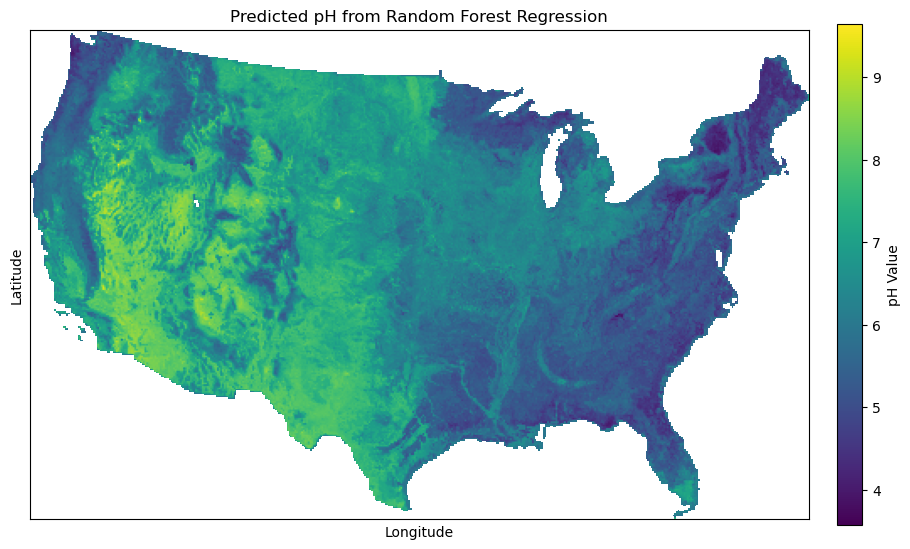

In [13]:
clip = load_zipped_pickle("clipindices")
with rasterio.open(output_path, 'r+') as src:
    data = src.read(1)
    data[clip] = float('nan')
    kwargs = src.meta.copy()
    kwargs.update({'nodata': float('nan')})
    src.write(data, 1)
    
    extent = plotting_extent(src)
    
    plt.figure(figsize=(10, 8))  
    plt.imshow(data, extent=extent, cmap='viridis')
    plt.colorbar(label='pH Value', shrink=0.65, pad=0.03)  
    plt.title("Predicted pH from Random Forest Regression")
    plt.xlabel("Longitude")
    plt.ylabel("Latitude")
    plt.xticks([])  # Turn off ticks
    plt.yticks([]) 
    plt.tight_layout()  
    plt.savefig('figures/final_rf_map_tight', bbox_inches='tight')
    plt.show()


## EBK

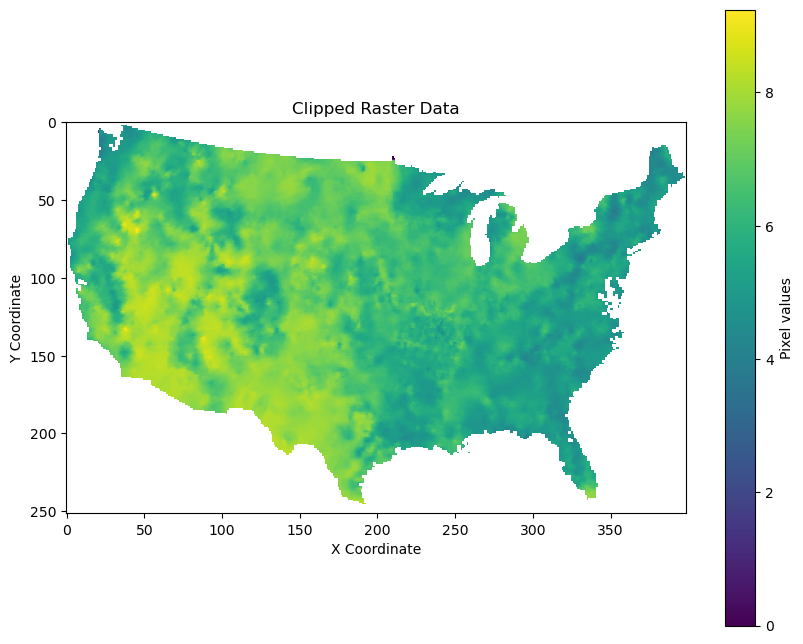

In [21]:
raster_path = "ebk_81.tif"
shapefile_path = "usa/usa.shp"
clipped_raster_path = "output/clipped_ebk_raster.tif"

shapefile = gpd.read_file(shapefile_path)
shapefile = shapefile.to_crs(epsg=5070)  
shapefile = shapefile[~shapefile['NAME'].isin(['U.S. Virgin Islands', 'Puerto Rico', 'Hawaii', 'Alaska'])]

with rasterio.open(raster_path) as src:
   
    raster_crs = src.crs.to_epsg()
    
    # Reproject raster to EPSG:5070
    if raster_crs != 5070:
        transform, width, height = calculate_default_transform(
            src.crs, 'EPSG:5070', src.width, src.height, *src.bounds
        )

        kwargs.update({
            'crs': 'EPSG:5070',
            'transform': transform,
            'width': width,
            'height': height
        })

        reprojected_raster = np.empty((src.count, height, width), dtype=np.float32)
        reproject(
            source=rasterio.band(src, 1),
            destination=reprojected_raster,
            src_transform=src.transform,
            src_crs=src.crs,
            dst_transform=transform,
            dst_crs='EPSG:5070',
            resampling=rasterio.enums.Resampling.nearest
        )

        with rasterio.open("reprojected_raster.tif", "w", **kwargs) as dst:
            dst.write(reprojected_raster)
        
        raster_path = "reprojected_raster.tif" 

    with rasterio.open(raster_path) as src:
        out_image, out_transform = mask(src, shapefile.geometry, crop=True)
        out_meta = src.meta.copy()

        out_meta.update({
            "driver": "GTiff",
            "count": 1,
            "height": out_image.shape[1],
            "width": out_image.shape[2],
            "transform": out_transform
        })

        with rasterio.open(clipped_raster_path, "w", **out_meta) as dest:
            dest.write(out_image)

with rasterio.open(clipped_raster_path) as clipped_src:
    clipped_image = clipped_src.read(1)
    clipped_image[clipped_image==clipped_image[0][0]] = float('nan')
    kwargs = src.meta.copy()

plt.figure(figsize=(10, 8))
plt.imshow(clipped_image, cmap='viridis')
plt.colorbar(label='Pixel values')
plt.title('Clipped Raster Data')
plt.xlabel('X Coordinate')
plt.ylabel('Y Coordinate')
plt.show()

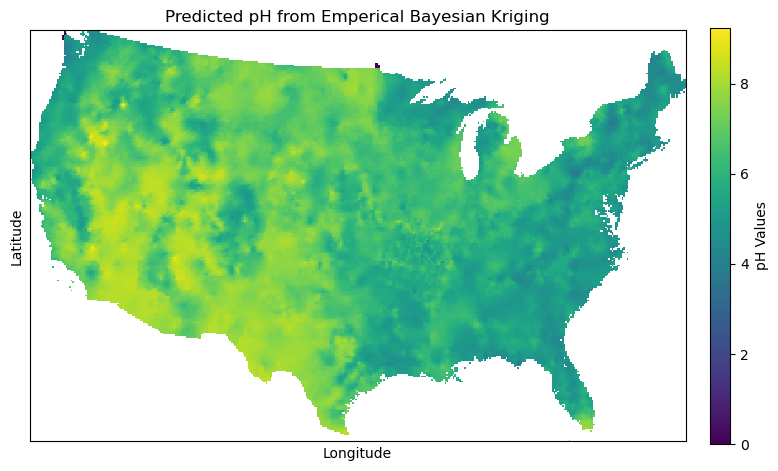

In [22]:
plt.figure(figsize=(10, 8))

# Remove NaN values 
clipped_image[clipped_image == clipped_image[0][0]] = float('nan')

plt.imshow(clipped_image, cmap='viridis', aspect='auto')
plt.colorbar(label='pH Values', shrink = 0.65, pad = 0.03)
plt.title('Predicted pH from Emperical Bayesian Kriging')
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.subplots_adjust(left=0.1, right=0.9, top=0.9, bottom=0.1)
masked_image = np.ma.masked_where(np.isnan(clipped_image), clipped_image)
plt.imshow(masked_image, cmap='viridis', interpolation='nearest')

non_nan_indices = np.where(~np.isnan(clipped_image))
x_min, x_max = np.min(non_nan_indices[1]), np.max(non_nan_indices[1])
y_min, y_max = np.min(non_nan_indices[0]), np.max(non_nan_indices[0])
plt.xlim(x_min, x_max)
plt.ylim(y_max, y_min)
plt.xticks([])  # Turn off x-axis ticks
plt.yticks([]) 
plt.savefig("figures/ebk_final_map", bbox_inches = 'tight')
plt.show()


# Extractvaluetopoints

In [23]:
# Validation
final_final = 'ebk_valid_81.csv'
df_val = pd.read_csv(final_final, low_memory=False)
df_val['geometry'] = df_val.apply(lambda row: Point(row['longitude_decimal_degrees'], row['latitude_decimal_degrees']), axis=1)
vali = gpd.GeoDataFrame(df_val, geometry='geometry')

In [24]:
valilat = vali['latitude_decimal_degrees'].values
valilon = vali['longitude_decimal_degrees'].values

In [25]:
valitransformedlat, valitransformedlon = transformer.transform(valilon, valilat)
vali_transformed_coords = np.vstack((valitransformedlat, valitransformedlon)).T #<----IMPORTANT

In [26]:
valipred = np.zeros((len(raster_paths),len(vali)))
for pi, (feature, path) in tqdm(enumerate(raster_paths.items()),total = len(raster_paths)):
    with rasterio.open(path,'r+') as src:
        dat = list(src.sample(vali_transformed_coords))
        h = np.array(dat).T[0]
        for j in range(len(vali)):
            valipred[pi,j] = h[j]

100%|███████████████████████████████████████████| 29/29 [00:04<00:00,  6.08it/s]


In [27]:
valiph = np.zeros(len(vali))
shifter = 'rf_pH_81.tif'
with rasterio.open(shifter,'r+') as src:
    dat = list(src.sample(vali_transformed_coords))
    h = np.array(dat).T[0]
    for j in range(len(vali)):
        valiph[j] = h[j]

In [28]:
vali['ph_h2o']

0       7.8
1       8.1
2       5.8
3       8.0
4       7.6
       ... 
5861    4.8
5862    4.9
5863    6.4
5864    6.1
5865    5.9
Name: ph_h2o, Length: 5866, dtype: float64

In [29]:
valiarr_new = np.column_stack([valipred.T,valitransformedlat, valitransformedlon]) 
vali_data = pd.DataFrame(valiarr_new,columns=of_interest)#<--- lat/long
# vali_data = pd.DataFrame(valipred.T, columns=of_interest) #this one works without
valis = model.predict(vali_data)

In [30]:
vali['phpred'] = valiph
vali['phpred_manual'] = valis
vali.head()

,OID_,OID1,Join_Count,TARGET_FID,Join_Count_1,TARGET_FID_1,OBJECTID,OBJECTID_x,objectid_1_x,pedon_key,...,StdError,Stdd_Error,NormValue,CRPS,QuanVal,Interval90,Interval95,geometry,phpred,phpred_manual
0,1,NaN,1,15868,1,15868,20017.0,31912.0,33771.0,33771.0,...,0.884196,0.096383,0.069495,0.210553,0.461513,Yes,Yes,POINT (-81.44444 24.68128),6.257162,5.886971
1,2,NaN,1,15871,1,15871,20020.0,31915.0,33774.0,33774.0,...,1.053236,-0.044053,-0.074207,0.247644,0.517902,Yes,Yes,POINT (-80.80203 24.83461),6.182833,6.047500
2,3,NaN,1,21622,1,21622,26673.0,48987.0,51621.0,51621.0,...,1.010769,2.229784,2.133284,1.694244,0.013064,No,No,POINT (-80.70193 24.87710),6.312050,5.548229
3,4,NaN,1,20645,1,20645,25696.0,47958.0,50592.0,50592.0,...,0.687111,-0.588756,-0.621767,0.251934,0.723104,Yes,Yes,POINT (-80.43677 25.46194),6.449000,6.792000
4,5,NaN,1,21402,1,21402,26453.0,48760.0,51394.0,51394.0,...,0.614072,0.174247,0.144722,0.150189,0.429140,Yes,Yes,POINT (-80.54481 25.50563),6.822000,6.562333


In [31]:
vali.to_pickle('vali.pkl')

In [32]:
vali['rf_er_abs']= abs(vali['ph_h2o'] - vali['phpred'])
vali['rf_er_abs_manual']= abs(vali['ph_h2o'] - vali['phpred_manual'])

print(vali['rf_er_abs'].mean())
print(vali['rf_er_abs_manual'].mean())

0.6343878656939008
0.662415958443092
